In [1]:
'''
Group members:
Bohao XU        ETU20211498
Jijun TAN       ETU20211472
Yilin ZHANG     ETU20211520
Junxin HUANG    ETU20211420
'''

'\nGroup members:\nBohao XU        ETU20211498\nJijun TAN       ETU20211472\nYilin ZHANG     ETU20211520\nJunxin HUANG    ETU20211420\n'

In [2]:
'''
README!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

1. please download the dataset from:
https://www.kaggle.com/competitions/g-research-crypto-forecasting/data

2. please make sure all the files downloaded are placed in the same folder as all the files I submitted to you.

3. then you can run the Model_Training.ipynb and Model_Inference.ipynb
'''

'\nREADME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n1. please download the dataset from:\nhttps://www.kaggle.com/competitions/g-research-crypto-forecasting/data\n\n2. please make sure all the files downloaded are placed in the same folder as all the files I submitted to you.\n\n3. then you can run the Model_Training.ipynb and Model_Inference.ipynb\n'

In [3]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import datetime
from datetime import datetime
import gc
import csv
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

seed0 = 8586

creator='group4' # for create a certain flder since we 4 group members work in the same server
TRAIN_CSV = 'train.csv'
SUPPLE_TRAIN_CSV = 'supplemental_train.csv'
ASSET_DETAILS_CSV = 'asset_details.csv' 

ASSET_ID_SELECTED_FOR_TRAIN = [i for i in range(14)] # when you train a certain model for asset_id=x, write x in this tuple like (x,)
FEATURES_EXCLUDE = [] # for those features need to be excluded for training
N_TRIALS = 5 # 5 means that the bayes optimizer would iterate for 5 times

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 350)
pd.set_option('mode.chained_assignment', None)

# Hyper_parameters Setting

In [4]:
lags = [60,300,900]

# Range of hyperparameters to be tuned
param_ranges = {
'learning_rate': (0.15, 0.2), 
    'max_depth': (14, 18), 
    'num_leaves': (55, 85), 
    'lambda_l1': (3.2, 3.8), 
    'lambda_l2': (2.2, 2.8), 
    'max_bin': (900, 1100), 
    'min_data_in_leaf': (48, 80)
}

# Parameters that do not require tuning
params = {
    'early_stopping_rounds': 100,
    'objective': 'regression',
    'metric': 'correlation',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.9,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }


# Data_Cleaning

In [5]:
df_main = pd.read_csv('train.csv', usecols=['timestamp','Asset_ID', 'Close', 'Target','Volume'])
df_supple = pd.read_csv('supplemental_train.csv', usecols=['timestamp','Asset_ID', 'Close', 'Target','Volume'])
# Merge training data from 2 tables
df_train = pd.concat([df_main, df_supple])

In [6]:
df_train

,timestamp,Asset_ID,Close,Volume,Target
0,1514764860,2,2374.590000,1.923301e+01,-0.004218
1,1514764860,0,8.530000,7.838000e+01,-0.014399
2,1514764860,1,13850.176000,3.155006e+01,-0.014643
...,...,...,...,...,...
2518275,1642982400,13,0.057478,8.988253e+05,NaN
2518276,1642982400,12,0.200093,2.983796e+06,NaN
2518277,1642982400,11,156.550000,7.439747e+01,NaN


In [7]:
# Reconstruct all training data with timestamps as unique columns, ensuring that each row is only 1 timestamp and contains 14 ids of close,target,volume data
train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(14) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target','Volume']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])

100%|██████████| 14/14 [00:35<00:00,  2.53s/it]


In [8]:
# Delete columns from the original df before refactoring
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
train_merged

,timestamp,Close_0,Target_0,Volume_0,Close_1,Target_1,Volume_1,Close_2,Target_2,Volume_2,Close_3,Target_3,Volume_3,Close_4,Target_4,Volume_4,Close_5,Target_5,Volume_5,Close_6,Target_6,Volume_6,Close_7,Target_7,Volume_7,Close_8,Target_8,Volume_8,Close_9,Target_9,Volume_9,Close_10,Target_10,Volume_10,Close_11,Target_11,Volume_11,Close_12,Target_12,Volume_12,Close_13,Target_13,Volume_13
0,1514764860,8.530000,-0.014399,78.380000,13850.176000,-0.014643,31.550062,2374.590000,-0.004218,19.233005,NaN,NaN,NaN,NaN,NaN,NaN,7.657600,-0.013922,6626.713370,738.507500,-0.004809,335.987856,25.877000,-0.008264,121.087310,NaN,NaN,NaN,225.206667,-0.009791,411.896642,NaN,NaN,NaN,329.4600,NaN,6.635710,NaN,NaN,NaN,NaN,NaN,NaN
1,1514764920,8.514500,-0.015875,71.390000,13828.102000,-0.015037,31.046432,2372.286667,-0.004079,24.050259,NaN,NaN,NaN,NaN,NaN,NaN,7.656700,-0.014534,3277.475494,738.260000,-0.004441,232.793141,25.897000,-0.029902,1.468019,NaN,NaN,NaN,224.856667,-0.012991,3640.502706,NaN,NaN,NaN,329.4500,-0.009690,0.349420,NaN,NaN,NaN,NaN,NaN,NaN
2,1514764980,8.484800,-0.015410,1546.820000,13801.314000,-0.010309,55.061820,2372.063333,-0.002892,42.676438,NaN,NaN,NaN,NaN,NaN,NaN,7.651200,-0.012546,5623.557585,737.502500,-0.004206,174.138031,26.469500,-0.030832,76.163922,NaN,NaN,NaN,226.000000,-0.003572,328.350286,NaN,NaN,NaN,329.1900,0.006567,1.189553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122476,1642982280,384.201667,NaN,496.467537,36276.223333,NaN,49.867700,302.430000,NaN,198.196485,1.123465,NaN,430719.654610,0.141800,NaN,7.433686e+05,2.272983,NaN,14907.125055,2541.388571,NaN,821.614133,25.152780,NaN,1334.601131,0.814233,NaN,20511.345658,112.258000,NaN,790.632440,1831.573333,NaN,2.142748,156.5125,NaN,21.597886,0.200803,NaN,7.076212e+05,0.057509,NaN,1.301079e+06
2122477,1642982340,384.002000,NaN,368.684921,36276.623333,NaN,43.030556,302.562500,NaN,76.954035,1.124831,NaN,352929.794282,0.141800,NaN,7.287195e+05,2.275100,NaN,14559.759824,2541.040000,NaN,749.548301,25.135800,NaN,2410.205214,0.815833,NaN,9064.791667,112.342400,NaN,331.208442,1833.186000,NaN,3.985169,156.8940,NaN,51.115980,0.200968,NaN,1.988516e+05,0.057521,NaN,9.245588e+05
2122478,1642982400,382.930000,NaN,1490.571077,36221.987143,NaN,110.053151,302.112000,NaN,209.645675,1.121151,NaN,249923.229256,0.141391,NaN,1.009688e+06,2.264800,NaN,202194.015531,2536.151429,NaN,1057.765667,25.028067,NaN,6709.816310,0.812400,NaN,6019.269834,111.983333,NaN,1243.860266,1833.018333,NaN,4.190290,156.5500,NaN,74.397471,0.200093,NaN,2.983796e+06,0.057478,NaN,8.988253e+05


In [9]:
# Set the timestamp column as the index column, in order to facilitate the subsequent filling of vacant rows
train_merged = train_merged.set_index("timestamp")

In [10]:
train_merged

,Close_0,Target_0,Volume_0,Close_1,Target_1,Volume_1,Close_2,Target_2,Volume_2,Close_3,Target_3,Volume_3,Close_4,Target_4,Volume_4,Close_5,Target_5,Volume_5,Close_6,Target_6,Volume_6,Close_7,Target_7,Volume_7,Close_8,Target_8,Volume_8,Close_9,Target_9,Volume_9,Close_10,Target_10,Volume_10,Close_11,Target_11,Volume_11,Close_12,Target_12,Volume_12,Close_13,Target_13,Volume_13
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1514764860,8.530000,-0.014399,78.380000,13850.176000,-0.014643,31.550062,2374.590000,-0.004218,19.233005,NaN,NaN,NaN,NaN,NaN,NaN,7.657600,-0.013922,6626.713370,738.507500,-0.004809,335.987856,25.877000,-0.008264,121.087310,NaN,NaN,NaN,225.206667,-0.009791,411.896642,NaN,NaN,NaN,329.4600,NaN,6.635710,NaN,NaN,NaN,NaN,NaN,NaN
1514764920,8.514500,-0.015875,71.390000,13828.102000,-0.015037,31.046432,2372.286667,-0.004079,24.050259,NaN,NaN,NaN,NaN,NaN,NaN,7.656700,-0.014534,3277.475494,738.260000,-0.004441,232.793141,25.897000,-0.029902,1.468019,NaN,NaN,NaN,224.856667,-0.012991,3640.502706,NaN,NaN,NaN,329.4500,-0.009690,0.349420,NaN,NaN,NaN,NaN,NaN,NaN
1514764980,8.484800,-0.015410,1546.820000,13801.314000,-0.010309,55.061820,2372.063333,-0.002892,42.676438,NaN,NaN,NaN,NaN,NaN,NaN,7.651200,-0.012546,5623.557585,737.502500,-0.004206,174.138031,26.469500,-0.030832,76.163922,NaN,NaN,NaN,226.000000,-0.003572,328.350286,NaN,NaN,NaN,329.1900,0.006567,1.189553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642982280,384.201667,NaN,496.467537,36276.223333,NaN,49.867700,302.430000,NaN,198.196485,1.123465,NaN,430719.654610,0.141800,NaN,7.433686e+05,2.272983,NaN,14907.125055,2541.388571,NaN,821.614133,25.152780,NaN,1334.601131,0.814233,NaN,20511.345658,112.258000,NaN,790.632440,1831.573333,NaN,2.142748,156.5125,NaN,21.597886,0.200803,NaN,7.076212e+05,0.057509,NaN,1.301079e+06
1642982340,384.002000,NaN,368.684921,36276.623333,NaN,43.030556,302.562500,NaN,76.954035,1.124831,NaN,352929.794282,0.141800,NaN,7.287195e+05,2.275100,NaN,14559.759824,2541.040000,NaN,749.548301,25.135800,NaN,2410.205214,0.815833,NaN,9064.791667,112.342400,NaN,331.208442,1833.186000,NaN,3.985169,156.8940,NaN,51.115980,0.200968,NaN,1.988516e+05,0.057521,NaN,9.245588e+05
1642982400,382.930000,NaN,1490.571077,36221.987143,NaN,110.053151,302.112000,NaN,209.645675,1.121151,NaN,249923.229256,0.141391,NaN,1.009688e+06,2.264800,NaN,202194.015531,2536.151429,NaN,1057.765667,25.028067,NaN,6709.816310,0.812400,NaN,6019.269834,111.983333,NaN,1243.860266,1833.018333,NaN,4.190290,156.5500,NaN,74.397471,0.200093,NaN,2.983796e+06,0.057478,NaN,8.988253e+05


In [11]:
# The time interval between rows before patching, you can see that there are missing values
(train_merged.index[1:]-train_merged.index[:-1]).value_counts()

timestamp
60     2136666
120         80
180         10
        ...   
360          5
300          5
480          1
Name: count, Length: 7, dtype: int64

In [12]:
# Fill in missing rows - padding method
train_merged = train_merged.reindex(range(train_merged.index[0],train_merged.index[-1]+60,60),method='pad')
# after replenishment
(train_merged.index[1:]-train_merged.index[:-1]).value_counts()

timestamp
60    2136959
Name: count, dtype: int64

In [13]:
# Reducing timestamp indexes to normal columns
train_merged = train_merged.reset_index()
train_merged

,timestamp,Close_0,Target_0,Volume_0,Close_1,Target_1,Volume_1,Close_2,Target_2,Volume_2,Close_3,Target_3,Volume_3,Close_4,Target_4,Volume_4,Close_5,Target_5,Volume_5,Close_6,Target_6,Volume_6,Close_7,Target_7,Volume_7,Close_8,Target_8,Volume_8,Close_9,Target_9,Volume_9,Close_10,Target_10,Volume_10,Close_11,Target_11,Volume_11,Close_12,Target_12,Volume_12,Close_13,Target_13,Volume_13
0,1514764860,8.530000,-0.014399,78.380000,13850.176000,-0.014643,31.550062,2374.590000,-0.004218,19.233005,NaN,NaN,NaN,NaN,NaN,NaN,7.657600,-0.013922,6626.713370,738.507500,-0.004809,335.987856,25.877000,-0.008264,121.087310,NaN,NaN,NaN,225.206667,-0.009791,411.896642,NaN,NaN,NaN,329.4600,NaN,6.635710,NaN,NaN,NaN,NaN,NaN,NaN
1,1514764920,8.514500,-0.015875,71.390000,13828.102000,-0.015037,31.046432,2372.286667,-0.004079,24.050259,NaN,NaN,NaN,NaN,NaN,NaN,7.656700,-0.014534,3277.475494,738.260000,-0.004441,232.793141,25.897000,-0.029902,1.468019,NaN,NaN,NaN,224.856667,-0.012991,3640.502706,NaN,NaN,NaN,329.4500,-0.009690,0.349420,NaN,NaN,NaN,NaN,NaN,NaN
2,1514764980,8.484800,-0.015410,1546.820000,13801.314000,-0.010309,55.061820,2372.063333,-0.002892,42.676438,NaN,NaN,NaN,NaN,NaN,NaN,7.651200,-0.012546,5623.557585,737.502500,-0.004206,174.138031,26.469500,-0.030832,76.163922,NaN,NaN,NaN,226.000000,-0.003572,328.350286,NaN,NaN,NaN,329.1900,0.006567,1.189553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136957,1642982280,384.201667,NaN,496.467537,36276.223333,NaN,49.867700,302.430000,NaN,198.196485,1.123465,NaN,430719.654610,0.141800,NaN,7.433686e+05,2.272983,NaN,14907.125055,2541.388571,NaN,821.614133,25.152780,NaN,1334.601131,0.814233,NaN,20511.345658,112.258000,NaN,790.632440,1831.573333,NaN,2.142748,156.5125,NaN,21.597886,0.200803,NaN,7.076212e+05,0.057509,NaN,1.301079e+06
2136958,1642982340,384.002000,NaN,368.684921,36276.623333,NaN,43.030556,302.562500,NaN,76.954035,1.124831,NaN,352929.794282,0.141800,NaN,7.287195e+05,2.275100,NaN,14559.759824,2541.040000,NaN,749.548301,25.135800,NaN,2410.205214,0.815833,NaN,9064.791667,112.342400,NaN,331.208442,1833.186000,NaN,3.985169,156.8940,NaN,51.115980,0.200968,NaN,1.988516e+05,0.057521,NaN,9.245588e+05
2136959,1642982400,382.930000,NaN,1490.571077,36221.987143,NaN,110.053151,302.112000,NaN,209.645675,1.121151,NaN,249923.229256,0.141391,NaN,1.009688e+06,2.264800,NaN,202194.015531,2536.151429,NaN,1057.765667,25.028067,NaN,6709.816310,0.812400,NaN,6019.269834,111.983333,NaN,1243.860266,1833.018333,NaN,4.190290,156.5500,NaN,74.397471,0.200093,NaN,2.983796e+06,0.057478,NaN,8.988253e+05


In [14]:
# Fill the null with ffill, but limit it to 100 to prevent the error from being too large
for id in range(14):
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].ffill(limit=100)
    train_merged[f'Volume_{id}'] = train_merged[f'Volume_{id}'].ffill(limit=100)

In [15]:
train_merged

,timestamp,Close_0,Target_0,Volume_0,Close_1,Target_1,Volume_1,Close_2,Target_2,Volume_2,Close_3,Target_3,Volume_3,Close_4,Target_4,Volume_4,Close_5,Target_5,Volume_5,Close_6,Target_6,Volume_6,Close_7,Target_7,Volume_7,Close_8,Target_8,Volume_8,Close_9,Target_9,Volume_9,Close_10,Target_10,Volume_10,Close_11,Target_11,Volume_11,Close_12,Target_12,Volume_12,Close_13,Target_13,Volume_13
0,1514764860,8.530000,-0.014399,78.380000,13850.176000,-0.014643,31.550062,2374.590000,-0.004218,19.233005,NaN,NaN,NaN,NaN,NaN,NaN,7.657600,-0.013922,6626.713370,738.507500,-0.004809,335.987856,25.877000,-0.008264,121.087310,NaN,NaN,NaN,225.206667,-0.009791,411.896642,NaN,NaN,NaN,329.4600,NaN,6.635710,NaN,NaN,NaN,NaN,NaN,NaN
1,1514764920,8.514500,-0.015875,71.390000,13828.102000,-0.015037,31.046432,2372.286667,-0.004079,24.050259,NaN,NaN,NaN,NaN,NaN,NaN,7.656700,-0.014534,3277.475494,738.260000,-0.004441,232.793141,25.897000,-0.029902,1.468019,NaN,NaN,NaN,224.856667,-0.012991,3640.502706,NaN,NaN,NaN,329.4500,-0.009690,0.349420,NaN,NaN,NaN,NaN,NaN,NaN
2,1514764980,8.484800,-0.015410,1546.820000,13801.314000,-0.010309,55.061820,2372.063333,-0.002892,42.676438,NaN,NaN,NaN,NaN,NaN,NaN,7.651200,-0.012546,5623.557585,737.502500,-0.004206,174.138031,26.469500,-0.030832,76.163922,NaN,NaN,NaN,226.000000,-0.003572,328.350286,NaN,NaN,NaN,329.1900,0.006567,1.189553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136957,1642982280,384.201667,NaN,496.467537,36276.223333,NaN,49.867700,302.430000,NaN,198.196485,1.123465,NaN,430719.654610,0.141800,NaN,7.433686e+05,2.272983,NaN,14907.125055,2541.388571,NaN,821.614133,25.152780,NaN,1334.601131,0.814233,NaN,20511.345658,112.258000,NaN,790.632440,1831.573333,NaN,2.142748,156.5125,NaN,21.597886,0.200803,NaN,7.076212e+05,0.057509,NaN,1.301079e+06
2136958,1642982340,384.002000,NaN,368.684921,36276.623333,NaN,43.030556,302.562500,NaN,76.954035,1.124831,NaN,352929.794282,0.141800,NaN,7.287195e+05,2.275100,NaN,14559.759824,2541.040000,NaN,749.548301,25.135800,NaN,2410.205214,0.815833,NaN,9064.791667,112.342400,NaN,331.208442,1833.186000,NaN,3.985169,156.8940,NaN,51.115980,0.200968,NaN,1.988516e+05,0.057521,NaN,9.245588e+05
2136959,1642982400,382.930000,NaN,1490.571077,36221.987143,NaN,110.053151,302.112000,NaN,209.645675,1.121151,NaN,249923.229256,0.141391,NaN,1.009688e+06,2.264800,NaN,202194.015531,2536.151429,NaN,1057.765667,25.028067,NaN,6709.816310,0.812400,NaN,6019.269834,111.983333,NaN,1243.860266,1833.018333,NaN,4.190290,156.5500,NaN,74.397471,0.200093,NaN,2.983796e+06,0.057478,NaN,8.988253e+05


# Data_Exploration

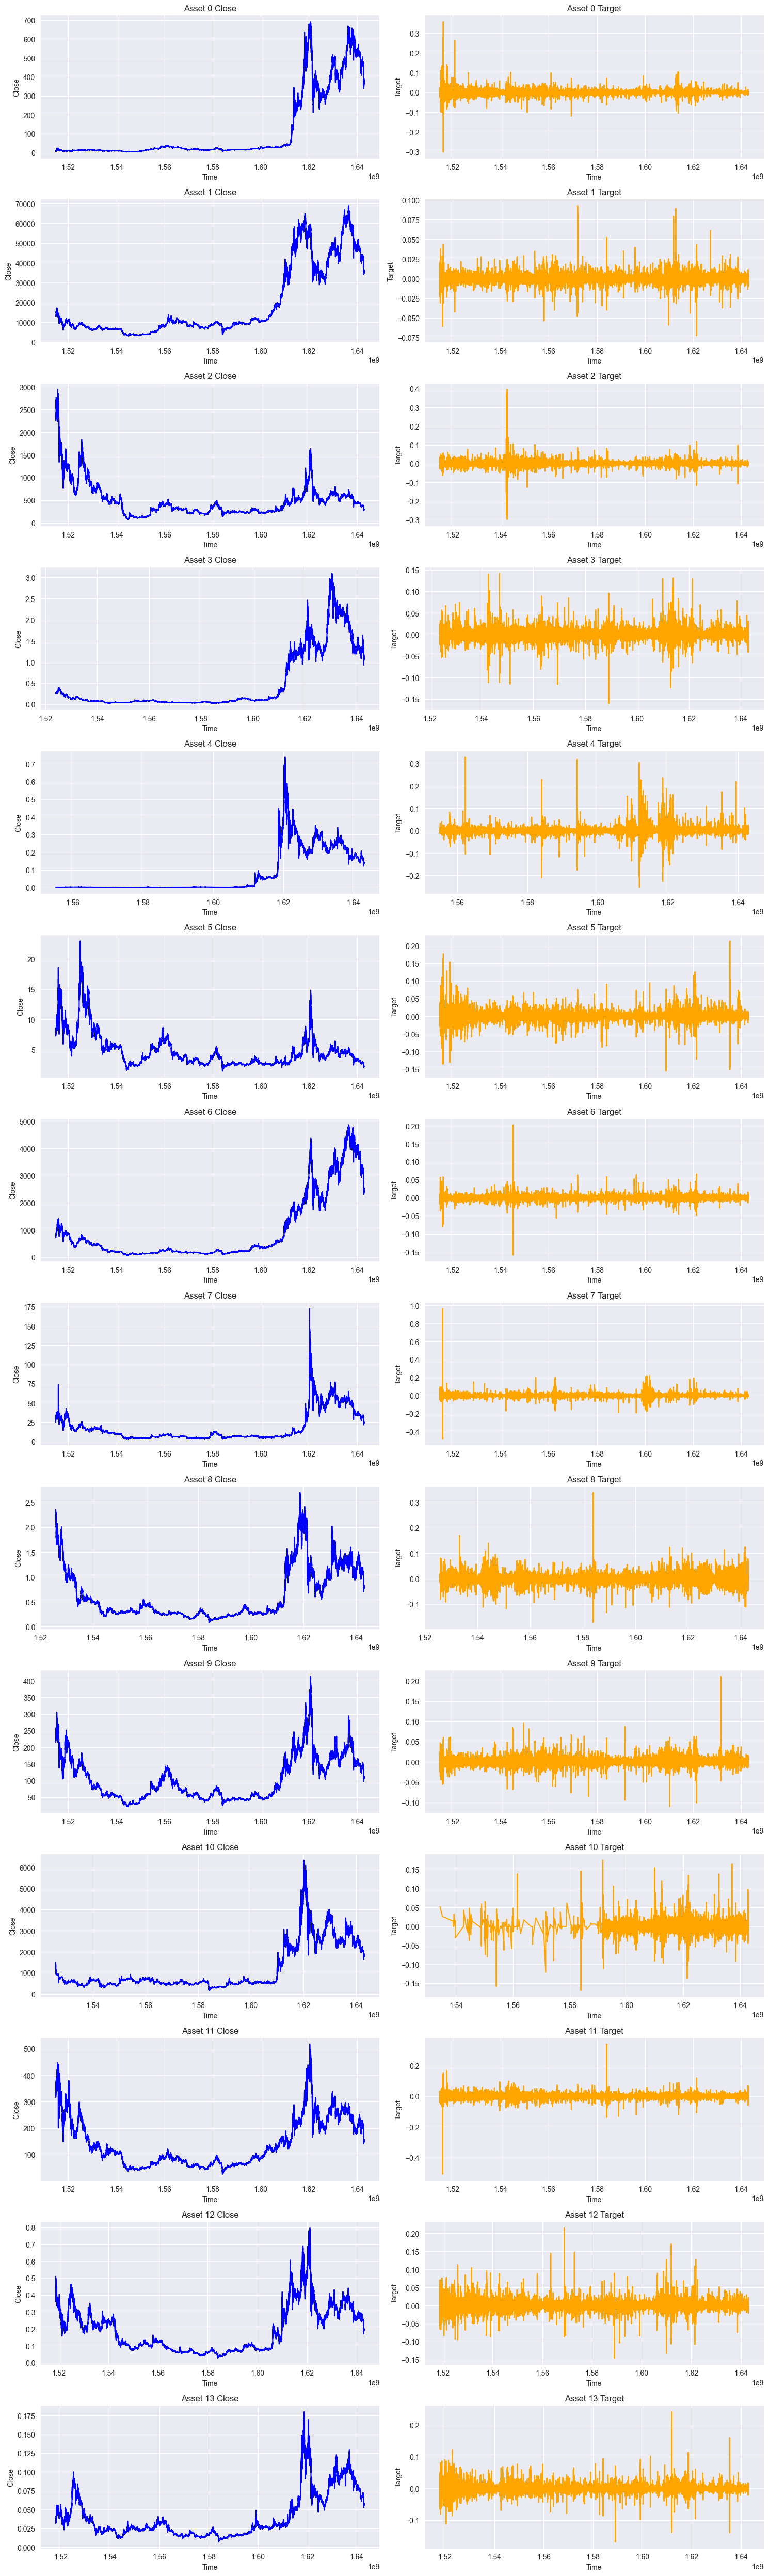

In [16]:
# extract 'Close' and 'Target'
close_columns = [f'Close_{i}' for i in range(14)]
target_columns = [f'Target_{i}' for i in range(14)]

train_merged.index = train_merged.index.astype('float64')

# plot Close and Target for each asset
plt.figure(figsize=(15, 50)) 
for i in range(14):
    # Visualize Close
    plt.subplot(14, 2, 2 * i + 1)  # The subplot in a layout of 14 rows and 2 columns, corresponds to the (2*i+1)-th subplot
    sns.lineplot(data=train_merged, x='timestamp', y=close_columns[i], dashes=False, color='blue')
    plt.title(f'Asset {i} Close')
    plt.xlabel('Time')
    plt.ylabel('Close')

    # visualize Target
    plt.subplot(14, 2, 2 * i + 2)  # The subplot in a layout of 14 rows and 2 columns corresponds to the (2*i+2)-th subplot.
    sns.lineplot(data=train_merged, x='timestamp', y=target_columns[i], dashes=False, color='orange')
    plt.title(f'Asset {i} Target')
    plt.xlabel('Time')
    plt.ylabel('Target')

plt.tight_layout()
plt.show()

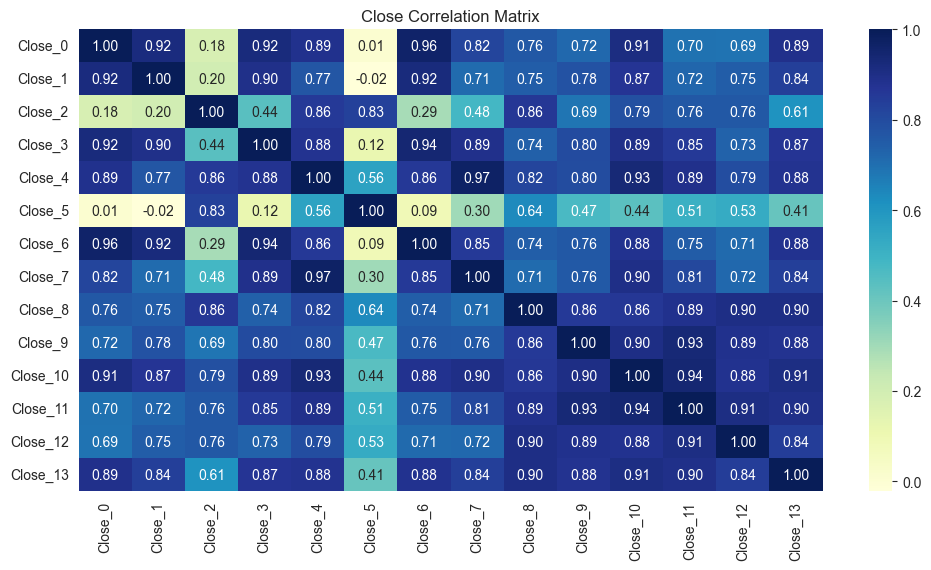

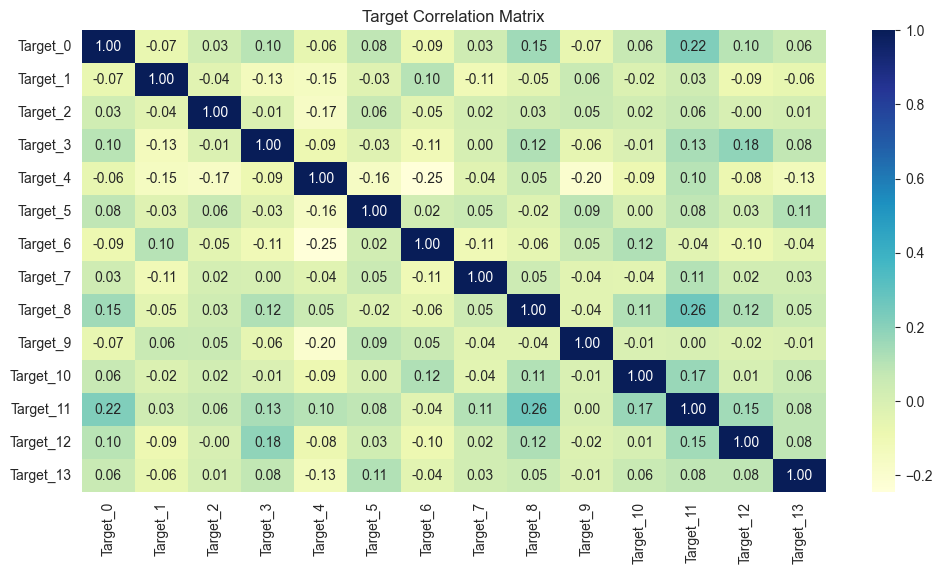

In [17]:
num_assets = 14

# extract 'Close' and 'Target
close_columns = [f'Close_{i}' for i in range(num_assets)]
target_columns = [f'Target_{i}' for i in range(num_assets)]

# Create DataFrame
train_merged_close = train_merged[close_columns]
train_merged_target = train_merged[target_columns]

# Compute correlation matrix
correlation_close = train_merged_close.corr()
correlation_target = train_merged_target.corr()

# visualize Close Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_close, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Close Correlation Matrix')
plt.show()

# visualize Target Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_target, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Target Correlation Matrix')
plt.show()

# Model_Training

In [18]:
# test_df is for training
test_df = train_merged

In [19]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [20]:
def MACD(df, short_term=12 * 30, long_term=26 * 30):
    '''Pass in a df and return the df with the 'MACD_id' columns'''
    tmp_col = ['EMA_short', 'EMA_long', 'DIF', 'DEA']
    for id in range(14):
        cols_to_select = [f'Close_{id}', 'timestamp', f'Target_{id}']
        df_selected = df[cols_to_select].sort_values('timestamp')

        # Calculate short-term (fast) moving averages（EMA12）
        df_selected['EMA_short'] = df_selected[f'Close_{id}'].ewm(span=short_term, adjust=False).mean()

        # Calculating long-term (slow) moving averages（EMA26）
        df_selected['EMA_long'] = df_selected[f'Close_{id}'].ewm(span=long_term, adjust=False).mean()

        # Calculation of deviation（DIF）
        df_selected['DIF'] = df_selected['EMA_short'] - df_selected['EMA_long']

        # Calculating the DEA using a 9-day exponential moving average
        df_selected['DEA'] = df_selected['DIF'].ewm(span=9, adjust=False).mean()

        # Calculating the MACD line
        df_selected[f'MACD_id{id}'] = df_selected['DIF'] - df_selected['DEA']

        # Merge back into the original DataFrame
        df = df.merge(df_selected[['timestamp', f'MACD_id{id}']], on='timestamp', how='left')

    # Check and delete temporary columns
    df.drop(columns=tmp_col, errors='ignore', inplace=True)
    return df

In [21]:
def VolumeRatio(df, mean_term=300):
    '''
    Pass in a df and return the df with the column 'Volume_Ratio_id'
    '''
    tmp_col = ['Volume_Mean']
    
    for id in range(14):
        # Calculate the 'Volume Mean' column, which represents the volume mean for the previous n days
        df[f'Volume_Mean'] = df[f'Volume_{id}'].rolling(window=mean_term).mean()
        
        # Calculate the 'Volume Ratio' column
        df[f'Volume_Ratio_id{id}'] = df[f'Volume_{id}'] / df[f'Volume_Mean']
    
    # Check and delete temporary columns
    df.drop(columns=tmp_col, errors='ignore', inplace=True)
    return df

In [22]:
def RSI(test_df, window_size=300):
    '''
    Pass in a df, return the df with the 'RSI_id' columns
    '''
    tmp_col = ['Price_Change', 'Gain', 'Loss', 'Avg_Gain', 'Avg_Loss', 'RS']
    
    for id in range(14):
        col_name = f'Close_{id}'
    
        # Calculate daily price changes
        test_df['Price_Change'] = test_df[col_name].diff()
    
        # Categorising price changes into upward and downward
        test_df['Gain'] = test_df['Price_Change'].apply(lambda x: x if x > 0 else 0)
        test_df['Loss'] = test_df['Price_Change'].apply(lambda x: -x if x < 0 else 0)
    
        # Calculation of the average of increase and decrease
        test_df['Avg_Gain'] = test_df['Gain'].rolling(window=window_size).mean()
        test_df['Avg_Loss'] = test_df['Loss'].rolling(window=window_size).mean()
    
        # Calculation of the relative strength index（RSI）
        test_df['RS'] = test_df['Avg_Gain'] / test_df['Avg_Loss']
        test_df[f'RSI_id{id}'] = 100 - (100 / (1 + test_df['RS']))
    
    test_df.drop(tmp_col, axis=1, inplace=True)
    return test_df

In [23]:
def get_features(df, train=True):   
    for id in range(14):    # 14
        for lag in lags: # 3
            # feature 1
            # Convolutional (smoothing) processing + fill in the vacant bits with 1 + roll rolls 1 to the top
            # This feature represents, for example, the logarithm of the price of asset 1 on day 60 versus the average price from day 1 - day 60
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            # feature 2
            # Logarithmic returns at lagged lag period for asset with id=id
            # This feature represents, for example, the logarithm of the ratio of the price of asset 1 on day 60 to the price on day 1
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags: #3
        # Feature A
        # This feature represents, for example, the mean of the 60th order lag of feature 1 for all assets. 
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        # Feature B
        # This feature represents, for example, the mean of the 60th order lag of feature 2 for all assets. 
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(14):
            # feature 5
            # This feature represents, for example, the difference between feature 1 and feature A of asset 1
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            # feature NO.6
            # This feature represents, for example, the difference between feature 2 and feature B for asset 1
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    for id in range(14):
        df = df.drop([f'Close_{id}'], axis=1)
        df = df.drop([f'Volume_{id}'],axis=1)

    return df

In [24]:
def replace_below_first_non_empty_900_nan(column):
    first_non_empty_index = column.first_valid_index()
    
    if first_non_empty_index is not None:
        column.loc[first_non_empty_index:first_non_empty_index+900] = np.nan
    return column

In [25]:
def OverallPerformSave(current_time,formatted_time,params_range_set,adjusted_params,params,asset_id,train_score,valid_socre,feature_importance):
    '''This is a function that outputs training results in real time during the training process. It helps us save the results of each round of training to a csv file so that we can view the results at the end of the training (or during the process).'''
    Overall_Performance_file_path =  '/kaggle/working/' + f'training_result/{creator}/整体表现{ASSET_ID_SELECTED_FOR_TRAIN}.csv'
    with open(Overall_Performance_file_path,'a',newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # write data
        csv_writer.writerow([current_time,formatted_time, str(params_range_set),str(adjusted_params),str(params), asset_id, train_score, valid_socre, feature_importance])

In [26]:
def CreateFolderForEachTraining(creator):
    '''
    This is the function used to create a folder where the csv files of the training results are stored, it creates a folder named after the current time before the start of each training session, under which all the files of this training session are stored.
    While creating the folder it creates a csv file which is written to the table header. This csv file is used to write the hyperparameters, training scores, feature importance etc. for the current round in real time during the training process.
    '''
    # Specify the name of the folder to be created
    folder_name = formatted_time

    # Create a folder in the current directory
    base_path = os.getcwd() 
    folder_path = os.path.join(base_path, f'training_result/{creator}/', folder_name)
    os.makedirs(folder_path)
    models_trained_path = folder_path + '/models_trained'
    os.makedirs(models_trained_path)
    
    Overall_Performance_file_path = '/kaggle/working/' + f'training_result/{creator}/整体表现{ASSET_ID_SELECTED_FOR_TRAIN}.csv'
    # Check if 'Overall_Performance.csv' exists
    if not os.path.isfile(Overall_Performance_file_path):
        # If the file does not exist, create and write the table header
        with open(Overall_Performance_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Output_time','Start_time', 'Params_range_set','Adjusted_Params','Params', 'Asset_id', 'Train_score', 'Valid_score','Feature_importance'])
        
    
    # Write hyperparameters
    params_file_path = os.path.join(base_path, f'training_result/{creator}/', folder_name,'params.txt')

    # Open the file and write the parameters
    with open(params_file_path, 'w') as params_file:
        for key, value in params.items():
            value_str = str(value)
            params_file.write(f"{key}: {value_str}\n")
    print(f"Parameters have been written to '{params_file_path}'.")

In [27]:
def totimestamp(x):
    '''This is a date-timestamp conversion tool'''
    return np.int32(time.mktime(datetime.datetime.strptime(x, "%d/%m/%Y").timetuple()))# totimestamp("21/06/2021")

In [28]:
def correlation(y_true, y_pred):
    '''
    This is a function that evaluates whether or not to let the lgbm model perform earlystopping, and it is called at the completion of each weak learner build, returning the correlation coefficient score of the strong learner that the whole model is composed of when iterating over the current weak learner. We want this score to be as large as possible, so the third value of return is True according to lgbm's rules.
    '''
    # Calculate your evaluation metrics here, assuming result is your evaluation result
    correlation, _ = np.corrcoef(y_true, y_pred)

    # Returns a tuple containing the name of the evaluation metric, the value of the metric, and information on whether a larger metric is better or not
    return 'correlation', correlation[1], True

In [29]:
def correlation_scorer(y_true, y_pred):
    '''This is a function used to evaluate the correlation coefficient scores of two columns of data'''
    correlation, _ = np.corrcoef(y_true, y_pred)
    return correlation[1]

In [30]:
def get_train_valid_splits(data,test_size):
    '''
    This function is called inside the my_custom_cv function as we train each asset_id
    It returns the timestamp of the training set and validation set for the asset_id currently being trained
    This timestamp will be passed to the my_custom_cv function for the final division of the training and validation set
    '''
    all_train_timestamps = data['timestamp'].unique()

    whole_length = len(all_train_timestamps)
    test_length = int(test_size * whole_length)

    test_split = all_train_timestamps[-test_length:]
    train_split = all_train_timestamps[:(whole_length-test_length)]

    train_test_zip = zip([train_split], [test_split])
    return train_test_zip

In [31]:
def my_custom_cv(df_proc, asset_id):
    '''
    This is the function used to divide the training set from the validation set
    It returns x_train, y_train, x_val, y_val
    '''
    # Filter out rows with non-missing values in the f'Target_{asset_id}' column of the target variable.
    # folder_name = formatted_time
    df_proc = df_proc.loc[(df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])]

    train_test_zip = get_train_valid_splits(df_proc,test_size=0.2)
    train_split, test_split = zip(*train_test_zip)
    train_split = [item for sublist in train_split for item in sublist]
    test_split = [item for sublist in test_split for item in sublist]
    gc.collect()

    train_split_index = df_proc['timestamp'].isin(train_split)
    test_split_index = df_proc['timestamp'].isin(test_split)

    # Obtain sample matrices and target variables for training and validation sets
    X_train = df_proc.loc[train_split_index, features]
    y_train = df_proc.loc[train_split_index, f'Target_{asset_id}']
    X_val = df_proc.loc[test_split_index, features]
    y_val = df_proc.loc[test_split_index, f'Target_{asset_id}']

    print(f"number of train data: {X_train.shape[0]}")
    print(f"number of val data:   {X_val.shape[0]}")

    yield X_train, y_train, X_val, y_val

In [32]:
def objective(trial):
    '''
    This is the OBJECTIVE function of the Bayesian optimiser, which is called during each round of model training
    It guides the Bayesian optimiser in the direction we want it to go (i.e. to improve the correlation_score)
    It returns the correlation_score on the validation set
    '''
    # Copy from global parameters
    local_params = params.copy()

    # Setting the parameters to be optimised
    local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
    local_params['max_depth'] = trial.suggest_int('max_depth', *param_ranges['max_depth'])
    local_params['num_leaves'] = trial.suggest_int('num_leaves', *param_ranges['num_leaves'])
    local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
    local_params['lambda_l2'] = trial.suggest_uniform('lambda_l2', *param_ranges['lambda_l2'])
    local_params['max_bin'] = trial.suggest_int('max_bin', *param_ranges['max_bin'])
    local_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', *param_ranges['min_data_in_leaf'])

    # Creating a LightGBM model
    model = lgb.LGBMRegressor(**local_params,n_estimators=2500)

    # Create 4 lists for receiving the true and predicted values for each fold (used to hold the results of a single round of training if k-fold cross-validation is not used)
    all_y_pred = []
    all_y_pred_on_train = []
    all_y_val = []
    all_y_train = []
    print('current_training_id:' + f'{asset_id}')
    print('current_Bayesian_trial:' + f'{trial_num} '+f'out of {N_TRIALS}')
    
    # Train each k-fold (or only 1 time if k-fold cross-validation is not used)
    for X_train, y_train, X_val, y_val in my_custom_cv(test_df,asset_id):
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)], 
                  eval_names=['tr', 'vl'], 
                  eval_metric=correlation, )
        
        y_pred_on_train = model.predict(X_train)
        y_pred = model.predict(X_val)
        
        all_y_pred_on_train.extend(y_pred_on_train)
        all_y_pred.extend(y_pred)
        all_y_val.extend(y_val)
        all_y_train.extend(y_train)
    
    # Calculate the training set score and validation set score separately
    all_trainset_score = correlation_scorer(all_y_pred_on_train,all_y_train)
    all_validset_score = correlation_scorer(all_y_pred,all_y_val)
    
    # Get the hyperparameters for the current training, which are used to write to a csv file to record the training information
    adjusted_params = {}
    for key, value in trial.params.items():
        adjusted_params[key] = value
    
    # Get feature importance and feature names for writing to csv file to record training information
    feature_importance = model.feature_importances_
    feature_names = model.booster_.feature_name()
    # Merge into a two-dimensional list
    merged_list = list(zip(feature_names, feature_importance))
    # Sort by size of feature_importance
    sorted_list = sorted(merged_list, key=lambda x: x[1], reverse=True)
    # Convert to Dictionary
    result_string = dict(sorted_list)
    
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # OverallPerformSave(current_time,formatted_time,param_ranges,adjusted_params,params,asset_id,all_trainset_score,all_validset_score,result_string)
    print(f'training_set_score: {all_trainset_score}')
    print(f'validation_set_score: {all_validset_score}')
    return all_validset_score

In [33]:
test_df

,timestamp,Close_0,Target_0,Volume_0,Close_1,Target_1,Volume_1,Close_2,Target_2,Volume_2,Close_3,Target_3,Volume_3,Close_4,Target_4,Volume_4,Close_5,Target_5,Volume_5,Close_6,Target_6,Volume_6,Close_7,Target_7,Volume_7,Close_8,Target_8,Volume_8,Close_9,Target_9,Volume_9,Close_10,Target_10,Volume_10,Close_11,Target_11,Volume_11,Close_12,Target_12,Volume_12,Close_13,Target_13,Volume_13
0.0,1514764860,8.530000,-0.014399,78.380000,13850.176000,-0.014643,31.550062,2374.590000,-0.004218,19.233005,NaN,NaN,NaN,NaN,NaN,NaN,7.657600,-0.013922,6626.713370,738.507500,-0.004809,335.987856,25.877000,-0.008264,121.087310,NaN,NaN,NaN,225.206667,-0.009791,411.896642,NaN,NaN,NaN,329.4600,NaN,6.635710,NaN,NaN,NaN,NaN,NaN,NaN
1.0,1514764920,8.514500,-0.015875,71.390000,13828.102000,-0.015037,31.046432,2372.286667,-0.004079,24.050259,NaN,NaN,NaN,NaN,NaN,NaN,7.656700,-0.014534,3277.475494,738.260000,-0.004441,232.793141,25.897000,-0.029902,1.468019,NaN,NaN,NaN,224.856667,-0.012991,3640.502706,NaN,NaN,NaN,329.4500,-0.009690,0.349420,NaN,NaN,NaN,NaN,NaN,NaN
2.0,1514764980,8.484800,-0.015410,1546.820000,13801.314000,-0.010309,55.061820,2372.063333,-0.002892,42.676438,NaN,NaN,NaN,NaN,NaN,NaN,7.651200,-0.012546,5623.557585,737.502500,-0.004206,174.138031,26.469500,-0.030832,76.163922,NaN,NaN,NaN,226.000000,-0.003572,328.350286,NaN,NaN,NaN,329.1900,0.006567,1.189553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136957.0,1642982280,384.201667,NaN,496.467537,36276.223333,NaN,49.867700,302.430000,NaN,198.196485,1.123465,NaN,430719.654610,0.141800,NaN,7.433686e+05,2.272983,NaN,14907.125055,2541.388571,NaN,821.614133,25.152780,NaN,1334.601131,0.814233,NaN,20511.345658,112.258000,NaN,790.632440,1831.573333,NaN,2.142748,156.5125,NaN,21.597886,0.200803,NaN,7.076212e+05,0.057509,NaN,1.301079e+06
2136958.0,1642982340,384.002000,NaN,368.684921,36276.623333,NaN,43.030556,302.562500,NaN,76.954035,1.124831,NaN,352929.794282,0.141800,NaN,7.287195e+05,2.275100,NaN,14559.759824,2541.040000,NaN,749.548301,25.135800,NaN,2410.205214,0.815833,NaN,9064.791667,112.342400,NaN,331.208442,1833.186000,NaN,3.985169,156.8940,NaN,51.115980,0.200968,NaN,1.988516e+05,0.057521,NaN,9.245588e+05
2136959.0,1642982400,382.930000,NaN,1490.571077,36221.987143,NaN,110.053151,302.112000,NaN,209.645675,1.121151,NaN,249923.229256,0.141391,NaN,1.009688e+06,2.264800,NaN,202194.015531,2536.151429,NaN,1057.765667,25.028067,NaN,6709.816310,0.812400,NaN,6019.269834,111.983333,NaN,1243.860266,1833.018333,NaN,4.190290,156.5500,NaN,74.397471,0.200093,NaN,2.983796e+06,0.057478,NaN,8.988253e+05


In [34]:
# Call custom feature engineering functions to get features
test_df = reduce_mem_usage(test_df)
test_df=MACD(test_df)
test_df=VolumeRatio(test_df)
test_df = RSI(test_df)
test_df=get_features(test_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 717.36 MB
Memory usage after optimization is: 240.48 MB
Decreased by 66.5%


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\3330322436.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\3330322436.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), 

Memory usage of dataframe is 2718.64 MB
Memory usage after optimization is: 945.62 MB
Decreased by 65.2%


In [35]:
# Remove the first 900 non-null values (eliminating rows affected by the maximum lag order)
test_df.iloc[:, 15:] = test_df.iloc[:, 15:].apply(replace_below_first_non_empty_900_nan, axis=0)

In [36]:
# Delete the first 900 rows (because the targets in the first 900 rows can't be used for training because their corresponding feature values are all NaN)
test_df = test_df.iloc[900:]

In [37]:
# Leaving 132,961 rows of data from the last final 3 months (2021-10-24 - 2022-1-24) as the prediction set for the final inference stage.
# At this point the training data is ready, it is 2003099*231 df, named test_df
test_df = test_df.loc[test_df['timestamp']<1635004800,]
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 901.66 MB
Memory usage after optimization is: 901.66 MB
Decreased by 0.0%


In [38]:
test_df

,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13,MACD_id0,MACD_id1,MACD_id2,MACD_id3,MACD_id4,MACD_id5,MACD_id6,MACD_id7,MACD_id8,MACD_id9,MACD_id10,MACD_id11,MACD_id12,MACD_id13,Volume_Ratio_id0,Volume_Ratio_id1,Volume_Ratio_id2,Volume_Ratio_id3,Volume_Ratio_id4,Volume_Ratio_id5,Volume_Ratio_id6,Volume_Ratio_id7,Volume_Ratio_id8,Volume_Ratio_id9,Volume_Ratio_id10,Volume_Ratio_id11,Volume_Ratio_id12,Volume_Ratio_id13,RSI_id0,RSI_id1,RSI_id2,RSI_id3,RSI_id4,RSI_id5,RSI_id6,RSI_id7,RSI_id8,RSI_id9,RSI_id10,RSI_id11,RSI_id12,RSI_id13,log_close/mean_60_id0,log_return_60_id0,log_close/mean_300_id0,log_return_300_id0,log_close/mean_900_id0,log_return_900_id0,log_close/mean_60_id1,log_return_60_id1,log_close/mean_300_id1,log_return_300_id1,log_close/mean_900_id1,log_return_900_id1,log_close/mean_60_id2,log_return_60_id2,log_close/mean_300_id2,log_return_300_id2,log_close/mean_900_id2,log_return_900_id2,log_close/mean_60_id3,log_return_60_id3,log_close/mean_300_id3,log_return_300_id3,log_close/mean_900_id3,log_return_900_id3,log_close/mean_60_id4,log_return_60_id4,log_close/mean_300_id4,log_return_300_id4,log_close/mean_900_id4,log_return_900_id4,log_close/mean_60_id5,log_return_60_id5,log_close/mean_300_id5,log_return_300_id5,log_close/mean_900_id5,log_return_900_id5,log_close/mean_60_id6,log_return_60_id6,log_close/mean_300_id6,log_return_300_id6,log_close/mean_900_id6,log_return_900_id6,log_close/mean_60_id7,log_return_60_id7,log_close/mean_300_id7,log_return_300_id7,log_close/mean_900_id7,log_return_900_id7,log_close/mean_60_id8,log_return_60_id8,log_close/mean_300_id8,log_return_300_id8,log_close/mean_900_id8,log_return_900_id8,log_close/mean_60_id9,log_return_60_id9,log_close/mean_300_id9,log_return_300_id9,log_close/mean_900_id9,log_return_900_id9,log_close/mean_60_id10,log_return_60_id10,log_close/mean_300_id10,log_return_300_id10,log_close/mean_900_id10,log_return_900_id10,log_close/mean_60_id11,log_return_60_id11,log_close/mean_300_id11,log_return_300_id11,log_close/mean_900_id11,log_return_900_id11,log_close/mean_60_id12,log_return_60_id12,log_close/mean_300_id12,log_return_300_id12,log_close/mean_900_id12,log_return_900_id12,log_close/mean_60_id13,log_return_60_id13,log_close/mean_300_id13,log_return_300_id13,log_close/mean_900_id13,log_return_900_id13,mean_close/mean_60,mean_log_returns_60,log_close/mean_60-mean_close/mean_60_id0,log_return_60-mean_log_returns_60_id0,log_close/mean_60-mean_close/mean_60_id1,log_return_60-mean_log_returns_60_id1,log_close/mean_60-mean_close/mean_60_id2,log_return_60-mean_log_returns_60_id2,log_close/mean_60-mean_close/mean_60_id3,log_return_60-mean_log_returns_60_id3,log_close/mean_60-mean_close/mean_60_id4,log_return_60-mean_log_returns_60_id4,log_close/mean_60-mean_close/mean_60_id5,log_return_60-mean_log_returns_60_id5,log_close/mean_60-mean_close/mean_60_id6,log_return_60-mean_log_returns_60_id6,log_close/mean_60-mean_close/mean_60_id7,log_return_60-mean_log_returns_60_id7,log_close/mean_60-mean_close/mean_60_id8,log_return_60-mean_log_returns_60_id8,log_close/mean_60-mean_close/mean_60_id9,log_return_60-mean_log_returns_60_id9,log_close/mean_60-mean_close/mean_60_id10,log_return_60-mean_log_returns_60_id10,log_close/mean_60-mean_close/mean_60_id11,log_return_60-mean_log_returns_60_id11,log_close/mean_60-mean_close/mean_60_id12,log_return_60-mean_log_returns_60_id12,log_close/mean_60-mean_close/mean_60_id13,log_return_60-mean_log_returns_60_id13,mean_close/mean_300,mean_log_returns_300,log_close/mean_300-mean_close/mean_300_id0,log_return_300-mean_log_returns_300_id0,log_close/mean_300-mean_close/mean_300_id1,log_return_300-mean_log_returns_300_id1,log_close/mean_300-mean_close/mean_300_id2,log_return_300-mean_log_returns_300_id2,log_close/mean_300-mean_close/mean_300_id3,log_return_300-mean_log_returns_300_id3,log_close/mean_300-mean_close/mean_300_id4,log_return_300-mean_log_returns_300_id4,lo

In [39]:
# Specify the column of features that need to be used for training
no_use_columns = [f'Target_{i}' for i in range(14)]
no_use_columns.append('timestamp')
no_use_columns.extend(FEATURES_EXCLUDE)
features = test_df.columns
features = features.drop(no_use_columns)
features = list(features)

In [40]:
features

['MACD_id0',
 'MACD_id1',
 'MACD_id2',
 'MACD_id3',
 'MACD_id4',
 'MACD_id5',
 'MACD_id6',
 'MACD_id7',
 'MACD_id8',
 'MACD_id9',
 'MACD_id10',
 'MACD_id11',
 'MACD_id12',
 'MACD_id13',
 'Volume_Ratio_id0',
 'Volume_Ratio_id1',
 'Volume_Ratio_id2',
 'Volume_Ratio_id3',
 'Volume_Ratio_id4',
 'Volume_Ratio_id5',
 'Volume_Ratio_id6',
 'Volume_Ratio_id7',
 'Volume_Ratio_id8',
 'Volume_Ratio_id9',
 'Volume_Ratio_id10',
 'Volume_Ratio_id11',
 'Volume_Ratio_id12',
 'Volume_Ratio_id13',
 'RSI_id0',
 'RSI_id1',
 'RSI_id2',
 'RSI_id3',
 'RSI_id4',
 'RSI_id5',
 'RSI_id6',
 'RSI_id7',
 'RSI_id8',
 'RSI_id9',
 'RSI_id10',
 'RSI_id11',
 'RSI_id12',
 'RSI_id13',
 'log_close/mean_60_id0',
 'log_return_60_id0',
 'log_close/mean_300_id0',
 'log_return_300_id0',
 'log_close/mean_900_id0',
 'log_return_900_id0',
 'log_close/mean_60_id1',
 'log_return_60_id1',
 'log_close/mean_300_id1',
 'log_return_300_id1',
 'log_close/mean_900_id1',
 'log_return_900_id1',
 'log_close/mean_60_id2',
 'log_return_60_id2',


In [ ]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
# CreateFolderForEachTraining(creator)
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV)

# Start training
for asset_id in ASSET_ID_SELECTED_FOR_TRAIN:
    asset_name = df_asset_details.loc[df_asset_details['Asset_ID'] == asset_id, 'Asset_Name'].values[0]
    print(f"Training model for {asset_name} (ID={asset_id:<2})")
    folder_name = formatted_time
    test_df = test_df.loc[(test_df[f'Target_{asset_id}'] == test_df[f'Target_{asset_id}'])]
    # The Bayesian optimiser is applied here
    trial_num = 1
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=N_TRIALS)

    # Print the result of optimization
    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

Training model for Binance Coin (ID=0 )


[I 2023-12-07 09:04:29,535] A new study created in memory with name: no-name-ad4ce9d9-615e-4af1-bc5c-8c1e41cdef72
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

current_training_id:0
current_Bayesian_trial:1 out of 5
number of train data: 1580216
number of val data:   395053
training_set_score: 0.18032702598045178
validation_set_score: 0.03529732378887933


[I 2023-12-07 09:07:25,349] Trial 0 finished with value: 0.03529732378887933 and parameters: {'learning_rate': 0.1873576402858712, 'max_depth': 18, 'num_leaves': 85, 'lambda_l1': 3.46997126910888, 'lambda_l2': 2.593631103168219, 'max_bin': 921, 'min_data_in_leaf': 62}. Best is trial 0 with value: 0.03529732378887933.
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uni

current_training_id:0
current_Bayesian_trial:1 out of 5
number of train data: 1580216
number of val data:   395053


[I 2023-12-07 09:10:24,818] Trial 1 finished with value: 0.035889867197571985 and parameters: {'learning_rate': 0.18982672119124108, 'max_depth': 16, 'num_leaves': 72, 'lambda_l1': 3.486100613573208, 'lambda_l2': 2.6338198269502833, 'max_bin': 1078, 'min_data_in_leaf': 77}. Best is trial 1 with value: 0.035889867197571985.


training_set_score: 0.1898825877905249
validation_set_score: 0.035889867197571985


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

current_training_id:0
current_Bayesian_trial:1 out of 5
number of train data: 1580216
number of val data:   395053


[I 2023-12-07 09:12:29,575] Trial 2 finished with value: 0.03253610411383731 and parameters: {'learning_rate': 0.16656681822652222, 'max_depth': 14, 'num_leaves': 65, 'lambda_l1': 3.307753724991213, 'lambda_l2': 2.560524118452328, 'max_bin': 1004, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.035889867197571985.


training_set_score: 0.19365990916804857
validation_set_score: 0.03253610411383731
current_training_id:0
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1580216
number of val data:   395053


[I 2023-12-07 09:14:17,423] Trial 3 finished with value: 0.03733599477009746 and parameters: {'learning_rate': 0.1786196649863197, 'max_depth': 18, 'num_leaves': 74, 'lambda_l1': 3.5103801025664385, 'lambda_l2': 2.680082977539321, 'max_bin': 1023, 'min_data_in_leaf': 66}. Best is trial 3 with value: 0.03733599477009746.


training_set_score: 0.20198093919816879
validation_set_score: 0.03733599477009746
current_training_id:0
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1580216
number of val data:   395053


[I 2023-12-07 09:15:51,419] Trial 4 finished with value: 0.024707542874878707 and parameters: {'learning_rate': 0.17064613825828293, 'max_depth': 15, 'num_leaves': 85, 'lambda_l1': 3.4908392995774844, 'lambda_l2': 2.556199263289544, 'max_bin': 960, 'min_data_in_leaf': 72}. Best is trial 3 with value: 0.03733599477009746.


training_set_score: 0.12196986846942781
validation_set_score: 0.024707542874878707
Number of finished trials:  5
Best trial:
Value:  0.03733599477009746
Params: 
    learning_rate: 0.1786196649863197
    max_depth: 18
    num_leaves: 74
    lambda_l1: 3.5103801025664385
    lambda_l2: 2.680082977539321
    max_bin: 1023
    min_data_in_leaf: 66
Training model for Bitcoin (ID=1 )


[I 2023-12-07 09:15:54,603] A new study created in memory with name: no-name-4ebb156f-024d-4491-bcae-41c2704a4cd6
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

current_training_id:1
current_Bayesian_trial:1 out of 5
number of train data: 1580212
number of val data:   395052
training_set_score: 0.10558369166847116
validation_set_score: 0.036647354274876996


[I 2023-12-07 09:18:01,720] Trial 0 finished with value: 0.036647354274876996 and parameters: {'learning_rate': 0.18485731326075655, 'max_depth': 16, 'num_leaves': 65, 'lambda_l1': 3.2296451092446246, 'lambda_l2': 2.255007564991345, 'max_bin': 947, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.036647354274876996.
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.sugges

current_training_id:1
current_Bayesian_trial:1 out of 5
number of train data: 1580212
number of val data:   395052


[I 2023-12-07 09:19:52,820] Trial 1 finished with value: 0.0316865952432896 and parameters: {'learning_rate': 0.15963062411731452, 'max_depth': 18, 'num_leaves': 71, 'lambda_l1': 3.486789488286325, 'lambda_l2': 2.55206305507087, 'max_bin': 939, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.036647354274876996.


training_set_score: 0.10624198804110284
validation_set_score: 0.0316865952432896
current_training_id:1
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1580212
number of val data:   395052
training_set_score: 0.1416312459383978
validation_set_score: 0.033463656310675285


[I 2023-12-07 09:24:49,164] Trial 2 finished with value: 0.033463656310675285 and parameters: {'learning_rate': 0.15693195639811192, 'max_depth': 18, 'num_leaves': 85, 'lambda_l1': 3.266502395067818, 'lambda_l2': 2.2093055419868435, 'max_bin': 1014, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.036647354274876996.
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.sugge

current_training_id:1
current_Bayesian_trial:1 out of 5
number of train data: 1580212
number of val data:   395052


[I 2023-12-07 09:26:37,769] Trial 3 finished with value: 0.03579849579133255 and parameters: {'learning_rate': 0.15726567500857466, 'max_depth': 18, 'num_leaves': 60, 'lambda_l1': 3.357442811895271, 'lambda_l2': 2.5391826647445814, 'max_bin': 921, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.036647354274876996.


training_set_score: 0.09063045427558979
validation_set_score: 0.03579849579133255
current_training_id:1
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1580212
number of val data:   395052


[I 2023-12-07 09:28:15,869] Trial 4 finished with value: 0.03591442547973698 and parameters: {'learning_rate': 0.1670257498361083, 'max_depth': 16, 'num_leaves': 78, 'lambda_l1': 3.5434160770443888, 'lambda_l2': 2.560251077950477, 'max_bin': 999, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.036647354274876996.


training_set_score: 0.10199349943388204
validation_set_score: 0.03591442547973698
Number of finished trials:  5
Best trial:
Value:  0.036647354274876996
Params: 
    learning_rate: 0.18485731326075655
    max_depth: 16
    num_leaves: 65
    lambda_l1: 3.2296451092446246
    lambda_l2: 2.255007564991345
    max_bin: 947
    min_data_in_leaf: 67
Training model for Bitcoin Cash (ID=2 )


[I 2023-12-07 09:28:18,576] A new study created in memory with name: no-name-6c13801d-0b2b-43d2-9594-c11b5243b102
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

current_training_id:2
current_Bayesian_trial:1 out of 5
number of train data: 1574835
number of val data:   393708


[I 2023-12-07 09:29:57,522] Trial 0 finished with value: 0.0705704947786571 and parameters: {'learning_rate': 0.1893962607444842, 'max_depth': 18, 'num_leaves': 58, 'lambda_l1': 3.6843579944851603, 'lambda_l2': 2.2377437418054344, 'max_bin': 1028, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.0705704947786571.


training_set_score: 0.1314514461927376
validation_set_score: 0.0705704947786571
current_training_id:2
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1574835
number of val data:   393708


[I 2023-12-07 09:32:06,791] Trial 1 finished with value: 0.06710183145205212 and parameters: {'learning_rate': 0.1757020994788746, 'max_depth': 14, 'num_leaves': 65, 'lambda_l1': 3.221334740566026, 'lambda_l2': 2.573416837452669, 'max_bin': 1070, 'min_data_in_leaf': 66}. Best is trial 0 with value: 0.0705704947786571.


training_set_score: 0.11242490010335028
validation_set_score: 0.06710183145205212
current_training_id:2
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1574835
number of val data:   393708


[I 2023-12-07 09:33:52,578] Trial 2 finished with value: 0.0639860937007378 and parameters: {'learning_rate': 0.19396173370568717, 'max_depth': 17, 'num_leaves': 74, 'lambda_l1': 3.506628297633669, 'lambda_l2': 2.2871653019990563, 'max_bin': 1096, 'min_data_in_leaf': 75}. Best is trial 0 with value: 0.0705704947786571.


training_set_score: 0.09596996629831536
validation_set_score: 0.0639860937007378
current_training_id:2
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1574835
number of val data:   393708


[I 2023-12-07 09:35:49,166] Trial 3 finished with value: 0.06192730689551654 and parameters: {'learning_rate': 0.15749688487771926, 'max_depth': 18, 'num_leaves': 64, 'lambda_l1': 3.5478753492895407, 'lambda_l2': 2.5241345825283052, 'max_bin': 914, 'min_data_in_leaf': 48}. Best is trial 0 with value: 0.0705704947786571.


training_set_score: 0.13261936129127014
validation_set_score: 0.06192730689551654
current_training_id:2
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1574835
number of val data:   393708


[I 2023-12-07 09:37:42,555] Trial 4 finished with value: 0.07361580635430476 and parameters: {'learning_rate': 0.15528259913297013, 'max_depth': 17, 'num_leaves': 55, 'lambda_l1': 3.6523987956273105, 'lambda_l2': 2.5450693703560154, 'max_bin': 918, 'min_data_in_leaf': 53}. Best is trial 4 with value: 0.07361580635430476.


training_set_score: 0.12144993285961601
validation_set_score: 0.07361580635430476
Number of finished trials:  5
Best trial:
Value:  0.07361580635430476
Params: 
    learning_rate: 0.15528259913297013
    max_depth: 17
    num_leaves: 55
    lambda_l1: 3.6523987956273105
    lambda_l2: 2.5450693703560154
    max_bin: 918
    min_data_in_leaf: 53
Training model for Cardano (ID=3 )


[I 2023-12-07 09:37:46,699] A new study created in memory with name: no-name-f2f118bd-dc3f-43fb-9b7f-cc7ab0d24916
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

current_training_id:3
current_Bayesian_trial:1 out of 5
number of train data: 1432948
number of val data:   358236


[I 2023-12-07 09:42:43,014] Trial 0 finished with value: 0.06970537177076083 and parameters: {'learning_rate': 0.15671412623151773, 'max_depth': 17, 'num_leaves': 80, 'lambda_l1': 3.2771141489214375, 'lambda_l2': 2.2059388983126196, 'max_bin': 979, 'min_data_in_leaf': 58}. Best is trial 0 with value: 0.06970537177076083.


training_set_score: 0.24355665369453605
validation_set_score: 0.06970537177076083
current_training_id:3
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1432948
number of val data:   358236


[I 2023-12-07 09:46:03,347] Trial 1 finished with value: 0.06563879168526067 and parameters: {'learning_rate': 0.1528681472525418, 'max_depth': 16, 'num_leaves': 62, 'lambda_l1': 3.7819179536449843, 'lambda_l2': 2.2974880591739266, 'max_bin': 923, 'min_data_in_leaf': 78}. Best is trial 0 with value: 0.06970537177076083.


training_set_score: 0.21212529480036327
validation_set_score: 0.06563879168526067
current_training_id:3
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1432948
number of val data:   358236


[I 2023-12-07 09:49:06,673] Trial 2 finished with value: 0.0649114911641168 and parameters: {'learning_rate': 0.15446227288811545, 'max_depth': 18, 'num_leaves': 84, 'lambda_l1': 3.750512068095351, 'lambda_l2': 2.2102795030829907, 'max_bin': 1010, 'min_data_in_leaf': 64}. Best is trial 0 with value: 0.06970537177076083.


training_set_score: 0.20402513771860464
validation_set_score: 0.0649114911641168
current_training_id:3
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1432948
number of val data:   358236


[I 2023-12-07 09:51:48,085] Trial 3 finished with value: 0.0631704918467148 and parameters: {'learning_rate': 0.18365045475907027, 'max_depth': 16, 'num_leaves': 66, 'lambda_l1': 3.6955627224188645, 'lambda_l2': 2.594151828753703, 'max_bin': 1026, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.06970537177076083.


training_set_score: 0.19342578959042991
validation_set_score: 0.0631704918467148
current_training_id:3
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 1432948
number of val data:   358236


[I 2023-12-07 09:54:41,344] Trial 4 finished with value: 0.06638377790597806 and parameters: {'learning_rate': 0.16534445536858183, 'max_depth': 16, 'num_leaves': 79, 'lambda_l1': 3.756968055127362, 'lambda_l2': 2.561693838455343, 'max_bin': 1033, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.06970537177076083.


training_set_score: 0.1962081090768593
validation_set_score: 0.06638377790597806
Number of finished trials:  5
Best trial:
Value:  0.06970537177076083
Params: 
    learning_rate: 0.15671412623151773
    max_depth: 17
    num_leaves: 80
    lambda_l1: 3.2771141489214375
    lambda_l2: 2.2059388983126196
    max_bin: 979
    min_data_in_leaf: 58
Training model for Dogecoin (ID=4 )


[I 2023-12-07 09:54:43,233] A new study created in memory with name: no-name-26f8498f-65d2-485d-a64b-2acbe4254272
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

current_training_id:4
current_Bayesian_trial:1 out of 5
number of train data: 833264
number of val data:   208315


[I 2023-12-07 09:55:53,995] Trial 0 finished with value: 0.05156431631721559 and parameters: {'learning_rate': 0.17108676815576485, 'max_depth': 16, 'num_leaves': 74, 'lambda_l1': 3.7613773705331637, 'lambda_l2': 2.4887944812697556, 'max_bin': 1088, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.05156431631721559.


training_set_score: 0.37439452132602735
validation_set_score: 0.05156431631721559
current_training_id:4
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 833264
number of val data:   208315


[I 2023-12-07 09:56:59,220] Trial 1 finished with value: 0.06466344847086278 and parameters: {'learning_rate': 0.1570781881967906, 'max_depth': 15, 'num_leaves': 76, 'lambda_l1': 3.7099348244509214, 'lambda_l2': 2.781726315198254, 'max_bin': 1081, 'min_data_in_leaf': 52}. Best is trial 1 with value: 0.06466344847086278.


training_set_score: 0.3326341866899553
validation_set_score: 0.06466344847086278
current_training_id:4
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 833264
number of val data:   208315


[I 2023-12-07 11:51:00,869] Trial 2 finished with value: 0.06057828500848516 and parameters: {'learning_rate': 0.1613080858062166, 'max_depth': 15, 'num_leaves': 83, 'lambda_l1': 3.595709321735261, 'lambda_l2': 2.4985432905817992, 'max_bin': 1032, 'min_data_in_leaf': 51}. Best is trial 1 with value: 0.06466344847086278.


training_set_score: 0.400765299542544
validation_set_score: 0.06057828500848516
current_training_id:4
current_Bayesian_trial:1 out of 5


C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  local_params['learning_rate'] = trial.suggest_loguniform('learning_rate', *param_ranges['learning_rate'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lambda_l1'] = trial.suggest_uniform('lambda_l1', *param_ranges['lambda_l1'])
C:\Users\严厉的父亲\AppData\Local\Temp\ipykernel_24008\849264096.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  local_params['lam

number of train data: 833264
number of val data:   208315
